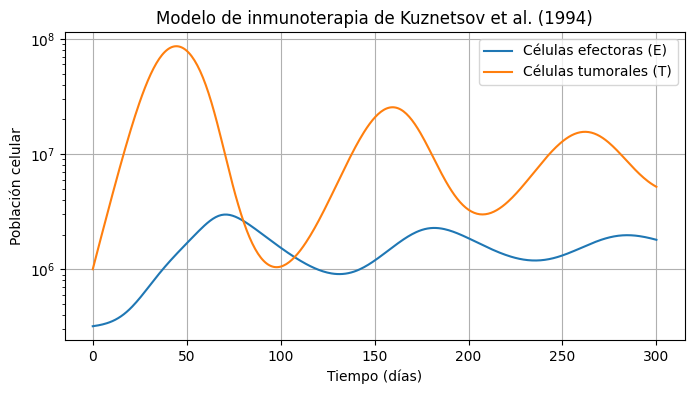

In [39]:
# Importando librerías necesarias
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Parámetros
s = 1.3e4      # tasa basal de llegada de efectores
p = 0.1245     # proliferación de efectores inducida por tumor
g = 2.0e7      # parámetro de saturación
m = 3.422e-10  # tasa de inactivación de efectores
n = 1.101e-7   # tasa de destrucción tumoral
d = 0.0412     # muerte natural de efectores
a = 0.18       # tasa de crecimiento tumoral
b = 2.0e-9     # capacidad de carga tumoral

# Definir el sistema de ecuaciones diferenciales
def kuz_system(t, vars):
    E, T = vars  # Efectores e inmunes
    dEdt = s + (p * E * T) / (g + T) - m * E * T - d * E
    dTdt = a * T * (1 - b * T) - n * E * T
    return [dEdt, dTdt]

# Condiciones iniciales
E0 = 3.2e5   # efectores iniciales
T0 = 1.0e6   # tumor inicial
initial_conditions = [E0, T0]

# Intervalo de tiempo para la simulación
time_span = (0, 300)  # días
t_eval = np.linspace(*time_span, 400)

# Resolver el sistema
solution = solve_ivp(kuz_system, time_span, initial_conditions, t_eval=t_eval, method='LSODA')

# Extraer la solución
t_values = solution.t
E_values = solution.y[0]
T_values = solution.y[1]

# Gráfico de poblaciones en el tiempo
plt.figure(figsize=(8, 4))
plt.plot(t_values, E_values, label='Células efectoras (E)')
plt.plot(t_values, T_values, label='Células tumorales (T)')
plt.xlabel('Tiempo (días)')
plt.ylabel('Población celular')
plt.title('Modelo de inmunoterapia de Kuznetsov et al. (1994)')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

In [40]:
#Convertimos a tensores
t_values = torch.tensor(t_values, dtype=torch.float32).view(-1, 1)
E_values = torch.tensor(E_values, dtype=torch.float32).view(-1, 1)
T_values = torch.tensor(T_values, dtype=torch.float32).view(-1, 1)

In [41]:
# Datos observacionales ruidosos
torch.manual_seed(10)

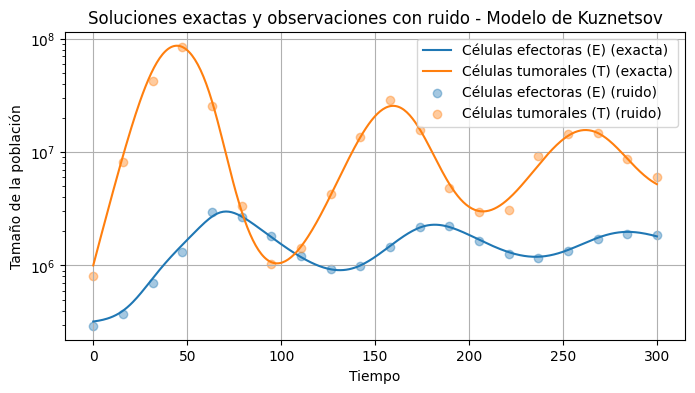

In [42]:
# Número de muestras equiespaciadas
n_obs = 20

# Índices equiespaciados desde 0 hasta el último índice
idx_obs = torch.linspace(0, t_values.shape[0] - 1, steps=n_obs).long()
t_obs = t_values[idx_obs]  # Tiempos observacionales

# Extraemos los valores exactos de E y T en esos tiempos
E_obs = E_values[idx_obs]
T_obs = T_values[idx_obs]

# Porcentaje de ruido relativo por punto
frac = 0.10

# normal truncada para evitar outliers muy grandes
zE = torch.clamp(torch.randn_like(E_obs), -2.0, 2.0)
zT = torch.clamp(torch.randn_like(T_obs), -2.0, 2.0)

E_obs_r = torch.clamp(E_obs + frac * E_obs * zE, min=0.0)
T_obs_r = torch.clamp(T_obs + frac * T_obs * zT, min=0.0)

#visualización
plt.figure(figsize=(8, 4))
plt.plot(t_values, E_values, label='Células efectoras (E) (exacta)')
plt.plot(t_values, T_values, label='Células tumorales (T) (exacta)')
plt.scatter(t_obs, E_obs_r, label="Células efectoras (E) (ruido)", alpha=0.4)
plt.scatter(t_obs, T_obs_r, label="Células tumorales (T) (ruido)", alpha=0.4)
plt.xlabel('Tiempo')
plt.ylabel('Tamaño de la población')
plt.title("Soluciones exactas y observaciones con ruido - Modelo de Kuznetsov")
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

In [43]:
# Red neuronal
class FCN(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(n_input, n_hidden),activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(n_hidden, n_hidden),activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Iter 0 | Loss=0.227333 | BC=0.089515 | Phys=0.064592 | Obs=0.153789 


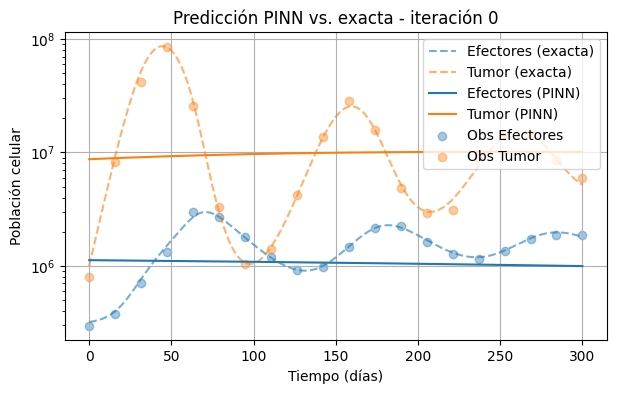

Iter 2500 | Loss=0.017192 | BC=0.000015 | Phys=0.002228 | Obs=0.014962 
Iter 5000 | Loss=0.006542 | BC=0.000088 | Phys=0.002625 | Obs=0.003908 


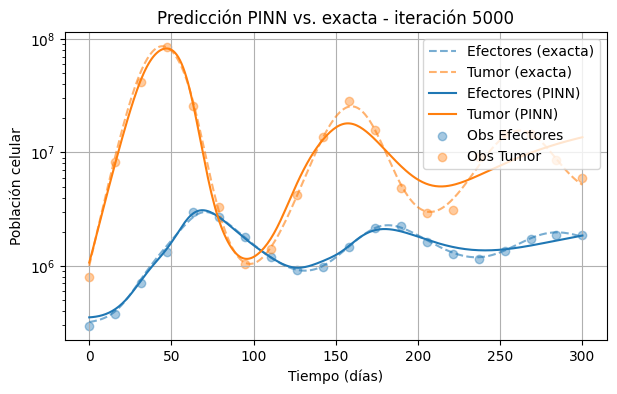

Iter 7500 | Loss=0.002483 | BC=0.000010 | Phys=0.001133 | Obs=0.001349 
Iter 10000 | Loss=0.002250 | BC=0.000012 | Phys=0.001048 | Obs=0.001201 


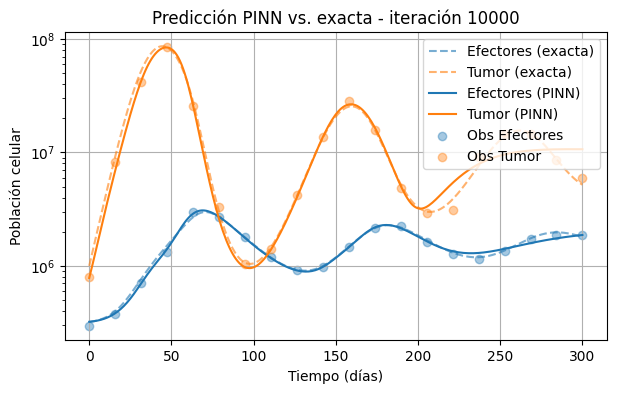

Iter 12500 | Loss=0.001157 | BC=0.000007 | Phys=0.000581 | Obs=0.000575 
Iter 15000 | Loss=0.000632 | BC=0.000010 | Phys=0.000363 | Obs=0.000268 


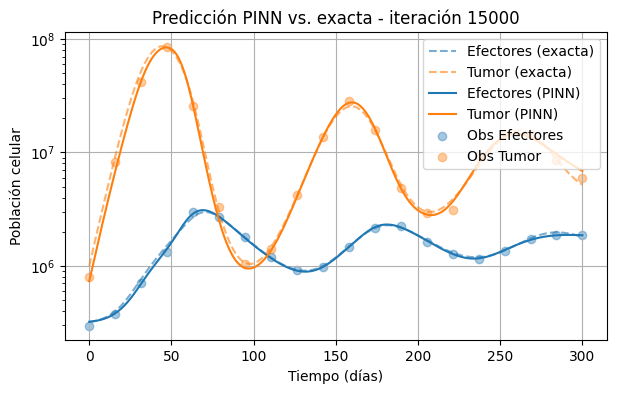

Iter 17500 | Loss=0.000567 | BC=0.000010 | Phys=0.000323 | Obs=0.000244 
Iter 20000 | Loss=0.000554 | BC=0.000010 | Phys=0.000313 | Obs=0.000240 


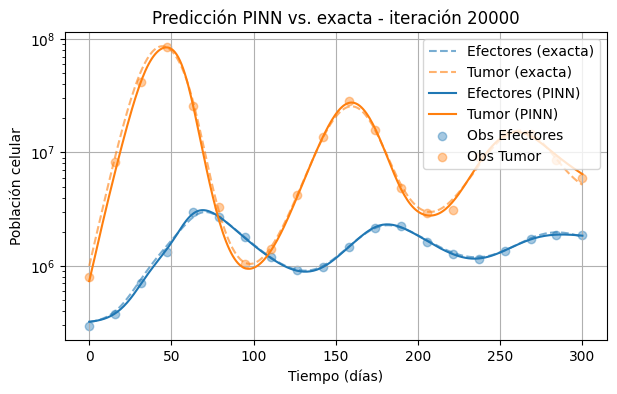

Iter 22500 | Loss=0.000539 | BC=0.000010 | Phys=0.000301 | Obs=0.000237 
Iter 25000 | Loss=0.000521 | BC=0.000011 | Phys=0.000284 | Obs=0.000236 


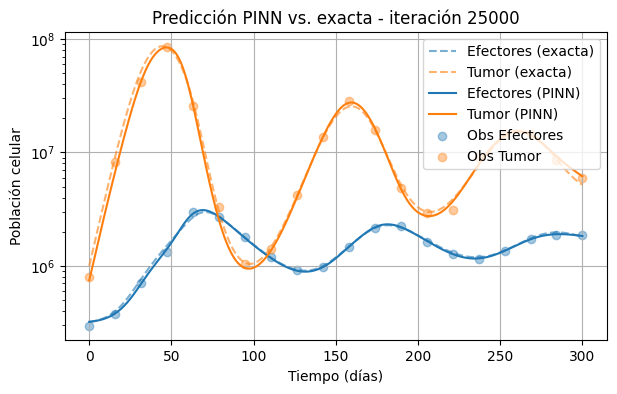

Iter 27500 | Loss=0.000514 | BC=0.000011 | Phys=0.000274 | Obs=0.000239 
Iter 30000 | Loss=0.000535 | BC=0.000014 | Phys=0.000293 | Obs=0.000240 


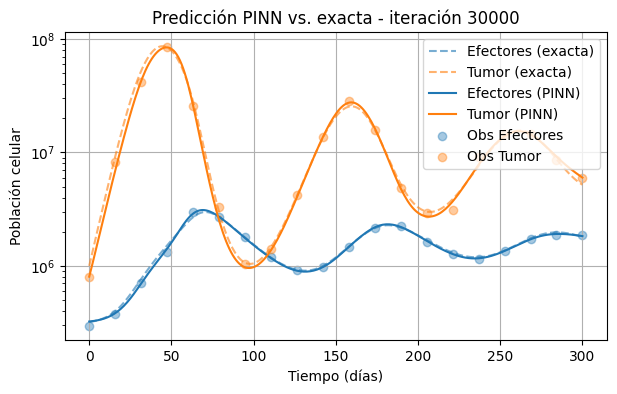

In [53]:
# Inicialización
torch.manual_seed(10)
pinn = FCN(1, 2, 16, 3)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# Cosine Annealing
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20000, eta_min=1e-6)

# Pesos
lambda_bc = 0.1
lambda_phys = 1
lambda_obs = 1

#Normalización
def normalize(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

def denormalize(xn, xmin, xmax):
    return xn * (xmax - xmin) + xmin

# Rango de datos
t_min, t_max = t_values.min(), t_values.max()
E_min, E_max = E_values.min(), E_values.max()
T_min, T_max = T_values.min(), T_values.max()

# Tiempos
t_boundary = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
t_physics = torch.tensor(solution.t, dtype=torch.float32).view(-1, 1).requires_grad_(True)
t_test = torch.linspace(time_span[0], time_span[1], 300).view(-1, 1)

# Normalizaciones
t_boundary_n = normalize(t_boundary, t_min, t_max).detach().requires_grad_(True)
t_physics_n = normalize(t_physics, t_min, t_max).detach().requires_grad_(True)
t_test_n = normalize(t_test, t_min, t_max)

t_obs_n = normalize(t_obs, t_min, t_max).detach().requires_grad_(True)
E_obs_r_n = normalize(E_obs_r, E_min, E_max)
T_obs_r_n = normalize(T_obs_r, T_min, T_max)

# Condiciones iniciales normalizadas
E0_norm = normalize(torch.tensor([[E0]], dtype=torch.float32), E_min, E_max)
T0_norm = normalize(torch.tensor([[T0]], dtype=torch.float32), T_min, T_max)

# Parámetros del modelo como tensores (fijos)
s_t, p_t, g_t, m_t, n_t, d_t, a_t, b_t = [torch.tensor(val, dtype=torch.float32)for val in [s, p, g, m, n, d, a, b]]

# Listas para pérdidas
loss_total_list, loss_bc_list, loss_phys_list, loss_obs_list = [], [], [], []

#Entrenamiento
for i in range(30001):
    optimizer.zero_grad()

    # BC en t=0
    E0_pred_n, T0_pred_n = pinn(t_boundary_n)[0]
    loss_bc = (E0_pred_n - E0_norm.squeeze())**2 + (T0_pred_n - T0_norm.squeeze())**2

    # Física
    pred_phys_n = pinn(t_physics_n)
    E_pred_n, T_pred_n = pred_phys_n[:, 0:1], pred_phys_n[:, 1:2]

    E_pred = denormalize(E_pred_n, E_min, E_max)
    T_pred = denormalize(T_pred_n, T_min, T_max)

    dE_dt_n = torch.autograd.grad(E_pred_n, t_physics_n, torch.ones_like(E_pred_n), create_graph=True)[0]
    dT_dt_n = torch.autograd.grad(T_pred_n, t_physics_n, torch.ones_like(T_pred_n), create_graph=True)[0]

    dE_dt = dE_dt_n / (t_max - t_min) * (E_max - E_min)
    dT_dt = dT_dt_n / (t_max - t_min) * (T_max - T_min)

    ode1 = dE_dt - (s_t + (p_t * E_pred * T_pred)/(g_t + T_pred) - m_t*E_pred*T_pred - d_t*E_pred)
    ode2 = dT_dt - (a_t * T_pred * (1 - b_t*T_pred) - n_t*E_pred*T_pred)

    scale1 = torch.abs(s_t) + torch.abs((p_t*E_pred*T_pred)/(g_t+T_pred)) + torch.abs(m_t*E_pred*T_pred) + torch.abs(d_t*E_pred) + 1e-8
    scale2 = torch.abs(a_t*T_pred*(1-b_t*T_pred)) + torch.abs(n_t*E_pred*T_pred) + 1e-8

    loss_phys = torch.mean((ode1/scale1)**2) + torch.mean((ode2/scale2)**2)

    # Observaciones
    pred_obs_n = pinn(t_obs_n)
    E_pred_obs_n, T_pred_obs_n = pred_obs_n[:, 0], pred_obs_n[:, 1]
    loss_obs = torch.mean((E_pred_obs_n - E_obs_r_n.squeeze())**2) + torch.mean((T_pred_obs_n - T_obs_r_n.squeeze())**2)

    # Total
    loss = lambda_bc*loss_bc + lambda_phys*loss_phys + lambda_obs*loss_obs
    loss.backward()
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    # Pérdidas
    loss_total_list.append(loss.item())
    loss_bc_list.append(loss_bc.item())
    loss_phys_list.append(loss_phys.item())
    loss_obs_list.append(loss_obs.item())

    if i % 2500 == 0:
        print(f"Iter {i} | Loss={loss.item():.6f} | BC={loss_bc.item():.6f} "
              f"| Phys={loss_phys.item():.6f} | Obs={loss_obs.item():.6f} ")

    if i % 5000 == 0:
        with torch.no_grad():
            pred_test_n = pinn(t_test_n)
            E_pred_test = denormalize(pred_test_n[:, 0], E_min, E_max).numpy()
            T_pred_test = denormalize(pred_test_n[:, 1], T_min, T_max).numpy()

            plt.figure(figsize=(7, 4))
            # Exactas
            plt.plot(t_values.numpy(), E_values.numpy(), '--', color='tab:blue',   alpha=0.6, label='Efectores (exacta)')
            plt.plot(t_values.numpy(), T_values.numpy(), '--', color='tab:orange', alpha=0.6, label='Tumor (exacta)')
            # PINN
            plt.plot(t_test.numpy(), E_pred_test, color='tab:blue',   label='Efectores (PINN)')
            plt.plot(t_test.numpy(), T_pred_test, color='tab:orange', label='Tumor (PINN)')
            # Obs
            plt.scatter(t_obs.numpy(), E_obs_r.numpy(), color='tab:blue',   alpha=0.4, label='Obs Efectores')
            plt.scatter(t_obs.numpy(), T_obs_r.numpy(), color='tab:orange', alpha=0.4, label='Obs Tumor')
            plt.xlabel("Tiempo (días)"); plt.ylabel("Población celular")
            plt.title(f"Predicción PINN vs. exacta - iteración {i}")
            plt.legend(loc='upper right'); plt.grid(True); plt.yscale('log'); plt.show()


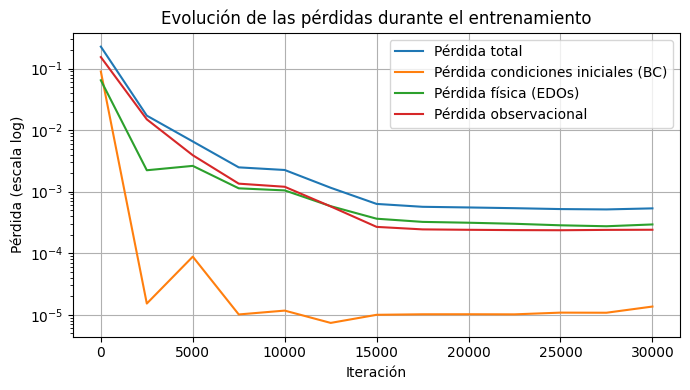

In [55]:
# Índices de iteración cada 2500 pasos
step = 2500
iters = list(range(0, len(loss_total_list), step))
loss_total_sub = loss_total_list[::step]
loss_bc_sub = loss_bc_list[::step]
loss_phys_sub = loss_phys_list[::step]
loss_obs_sub = loss_obs_list[::step]

# Gráfica de pérdidas
plt.figure(figsize=(7, 4))
plt.plot(iters, loss_total_sub, label='Pérdida total')
plt.plot(iters, loss_bc_sub, label='Pérdida condiciones iniciales (BC)')
plt.plot(iters, loss_phys_sub, label='Pérdida física (EDOs)')
plt.plot(iters, loss_obs_sub, label='Pérdida observacional')
plt.yscale('log')
plt.xlabel('Iteración')
plt.ylabel('Pérdida (escala log)')
plt.title('Evolución de las pérdidas durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()